In [1]:
%%capture

from cycler import cycler
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from palettable.cartocolors.sequential import agSunset_7_r
from palettable.cartocolors.qualitative import Bold_7
import pandas
import scipy.stats
import textwrap

from data.process import combined, map_filter_na_inplace

CMAP_SEQUENTIAL = agSunset_7_r.mpl_colormap
CMAP_QUALITATIVE = Bold_7.mpl_colormap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Noto Sans'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['grid.color'] = 'lightgrey'

df = combined()

# Report on Community Engagement

Municipal Broadband PDX, an advocacy campaign supporting digital equity in the Portland metropolitan area, is pleased to have the opportunity to research and report on local residents' engagement with the proposed publicly-owned network in Multnomah County.

(TODO: Finish this introduction.)

## Survey Findings


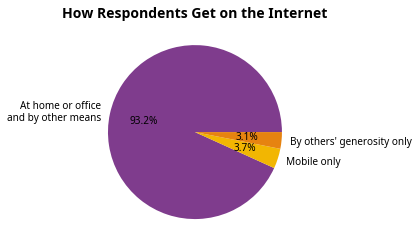

In [2]:
df.filter(['has_internet_premise', 'has_internet_mobile_only', 'has_internet_ext_only']).agg('sum').rename({
    'has_internet_premise': textwrap.fill('At home or office and by other means', 20),
    'has_internet_mobile_only': 'Mobile only',
    'has_internet_ext_only': "By others' generosity only",
}).plot(
    kind='pie',
    autopct='%.1f%%',
    title='How Respondents Get on the Internet',
    cmap=CMAP_QUALITATIVE,
)
plt.ylabel(None)

plt.show()

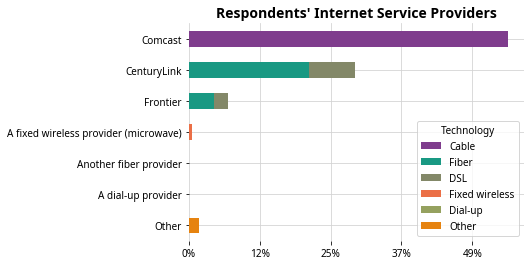

In [3]:
techs_by_provider = df.pivot_table(index='isp', columns='isp_tech', aggfunc='size')

ax = techs_by_provider.plot(kind='barh', stacked=True, cmap=CMAP_QUALITATIVE)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=df.has_internet_premise.count()))
ax.legend(fancybox=True, title='Technology')
ax.set_ylabel(None)
ax.invert_yaxis()

plt.title("Respondents' Internet Service Providers")

plt.show()

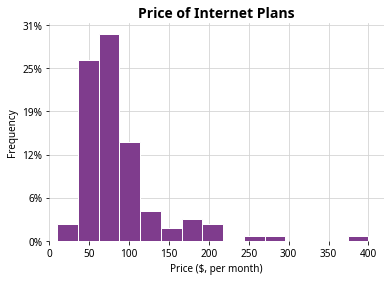

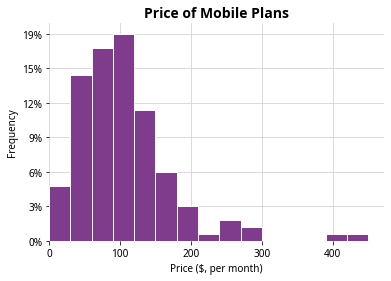

In [4]:
for col, label in {'internet_price': 'Internet', 'mobile_price': 'Mobile'}.items():
    plt.title('Price of {0} Plans'.format(label))
    plt.xlabel('Price ($, per month)')
    plt.ylabel('Count')
    plt.grid(True)

    ax = df[col].plot(kind='hist', bins=15, edgecolor='w', cmap=CMAP_QUALITATIVE)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.xlim(left=0)
    plt.show()

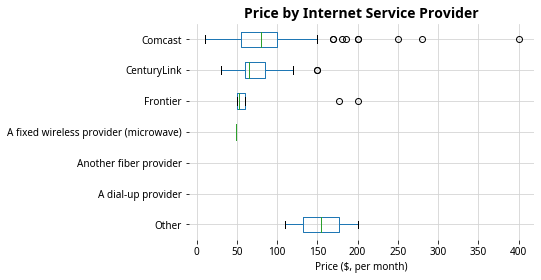

In [5]:
ax = df.boxplot(by='isp', column='internet_price', vert=False)
ax.invert_yaxis()

plt.title('Price by Internet Service Provider')
plt.suptitle(None)
plt.xlabel('Price ($, per month)')

plt.show()

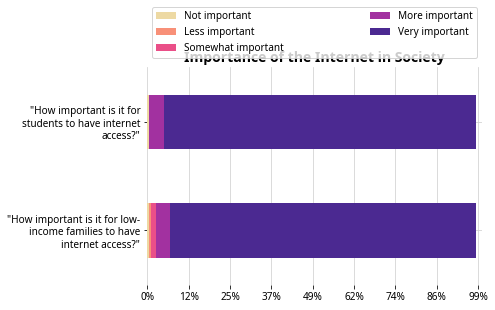

In [7]:
s = df.filter(['importance_student', 'importance_low_income']).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'importance_student': textwrap.fill('"How important is it for students to have internet access?"', 30),
    'importance_low_income': textwrap.fill('"How important is it for low-income families to have internet access?"', 30),
}, inplace=True)

ax = idf.plot(kind='barh', stacked=True, cmap=CMAP_SEQUENTIAL)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Importance of the Internet in Society")
plt.xlim(0, len(df.index))
plt.legend(loc='lower left', mode='expand', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2)

plt.show()

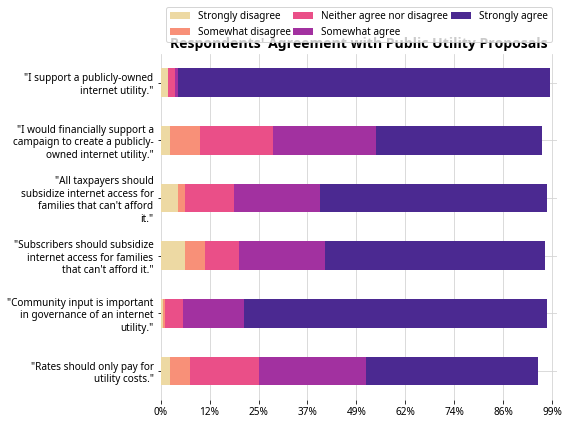

In [6]:
s = df.filter([
    'support_utility',
    'support_financial',
    'importance_user_input',
    'importance_rates_direct',
    'subsidize_subscribers',
    'subsidize_taxpayers',
]).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'support_utility': textwrap.fill('"I support a publicly-owned internet utility."', 30),
    'support_financial': textwrap.fill('"I would financially support a campaign to create a publicly-owned internet utility."', 30),
    'subsidize_taxpayers': textwrap.fill('"All taxpayers should subsidize internet access for families that can\'t afford it."', 30),
    'subsidize_subscribers': textwrap.fill('"Subscribers should subsidize internet access for families that can\'t afford it."', 30),
    'importance_user_input': textwrap.fill('"Community input is important in governance of an internet utility."', 30),
    'importance_rates_direct': textwrap.fill('"Rates should only pay for utility costs."', 30),
}, inplace=True)

ax = idf.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 6),
    cmap=CMAP_SEQUENTIAL,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Respondents' Agreement with Public Utility Proposals")
plt.xlim(0, len(df.index))
plt.legend(loc='lower left', mode='expand', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=3)
plt.tight_layout()

plt.show()

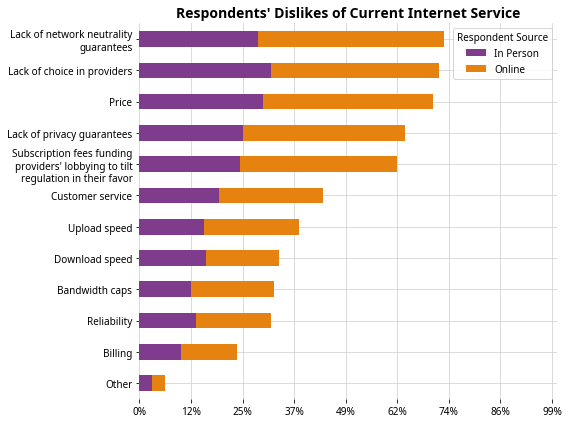

In [8]:
ddf = df.filter(['form', 'dislikes'])
ddf['online'] = ddf.form.apply(
    lambda cell: 'Online' if cell == 'English Online' else 'In Person',
)
ddf = ddf.explode('dislikes')
map_filter_na_inplace(
    lambda s: s.apply(lambda cell: textwrap.fill(cell, 30)),
    ddf, 'dislikes',
)
s = ddf.groupby(['online', 'dislikes']).size()
ddf_pivot = pandas.DataFrame(s).unstack(level=0)
ddf_pivot.columns = ddf_pivot.columns.droplevel()

ddf_pivot['sum'] = ddf_pivot.sum(axis=1)
ddf_pivot.sort_values('sum', inplace=True)
ddf_pivot.drop(columns=['sum'], inplace=True)

ax = ddf_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 6),
    cmap=CMAP_QUALITATIVE,
)
ax.legend(fancybox=True, title='Respondent Source')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Respondents' Dislikes of Current Internet Service")
plt.xlim(0, len(df.index))
plt.ylabel(None)
plt.tight_layout()

plt.show()